<a href="https://www.kaggle.com/code/mariuszcha/santander-prediction-v1?scriptVersionId=128537406" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/10385/logos/thumb76_76.png?t=2019-02-15-16-53-52)The aim of this project is to predict which customers of Santander Bank will carry out a transaction, using a dataset provided by the institution. The data of each customer has been anonymized to protect their privacy. The data provided for this competition has the same structure as the real data we(Santander's Scientists) have available to solve this problem. To assess the quality of our predictions, we will be using the ROC AUC (Receiver Operating Characteristic Area Under Curve) metric, which allows for evaluating the performance of a model by analyzing the ROC curve and calculating the area under the curve.

![](https://images.pexels.com/photos/351264/pexels-photo-351264.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2)

Our evaluation matric is **ROC AUC Curve.**
The ROC AUC Curve is a way to evaluate the performance of a binary classification model, and provides a visual representation of the trade-off between the True Positive Rate and False Positive Rate. A high AUC score and a curve that is as close to the top left corner of the graph as possible indicate good performance of the model.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from catboost import CatBoostClassifier
import lightgbm as lgb

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_palette('flare')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Reading test data and train data.
train_df = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/train.csv', index_col=0)
test_df = pd.read_csv('/kaggle/input/santander-customer-transaction-prediction/test.csv', index_col=0)

# Creating list of column names.
features = [x for x in train_df if x.startswith('var')]

#X and y
X = train_df[features]
y = train_df.target

# EDA
**In our first step we will examine whether there are Missing Values in our data sets**

In [3]:
def isMissing(df):
    missing_values = df.isna().sum()
    total_missings = missing_values.sum()
    print('Number of NAs in set:', total_missings)

isMissing(train_df)
isMissing(test_df)

Number of NAs in set: 0
Number of NAs in set: 0


Above - we counted missing values across whole set - and we can notice that there aren't any missing values

**Now we will check distributions of data for independent variables and for dependent one. We could plot all of them but that requires a lot of CPU Usage. As we are builing the model in order to learn something new - we will select TOP15 important features according to Correlation Matrix and work mostly based on them. We will examine te STD, Mean, MAX, MIN using .describe()**

In [4]:
# We create list of TOP 15 features
significant_features = train_df.corr().abs()['target'].sort_values(ascending=False)[1:16].index.tolist()
display(train_df.describe())
display(test_df.describe())

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


As we can see from tables above for Test data and Train data and from graphs below - our data is mostly normal distributed. There isn't any skewness. We can have some outliers values so to scale data - we will use RobustScaler. Obviously we don't know the whole set. Maybe the rest variables are less normal - but the ones which are crucial for modeling are fine.
One of concerns i have is Kurtosis. We can notice that some of them have problem with that indicator.
Kurtosis helps to identify the presence of outliers or extreme values in a dataset.
A distribution with positive kurtosis has heavier tails than a normal distribution, which means it has more outliers or extreme values. A distribution with negative kurtosis has lighter tails than a normal distribution, which means it has fewer outliers or extreme values.


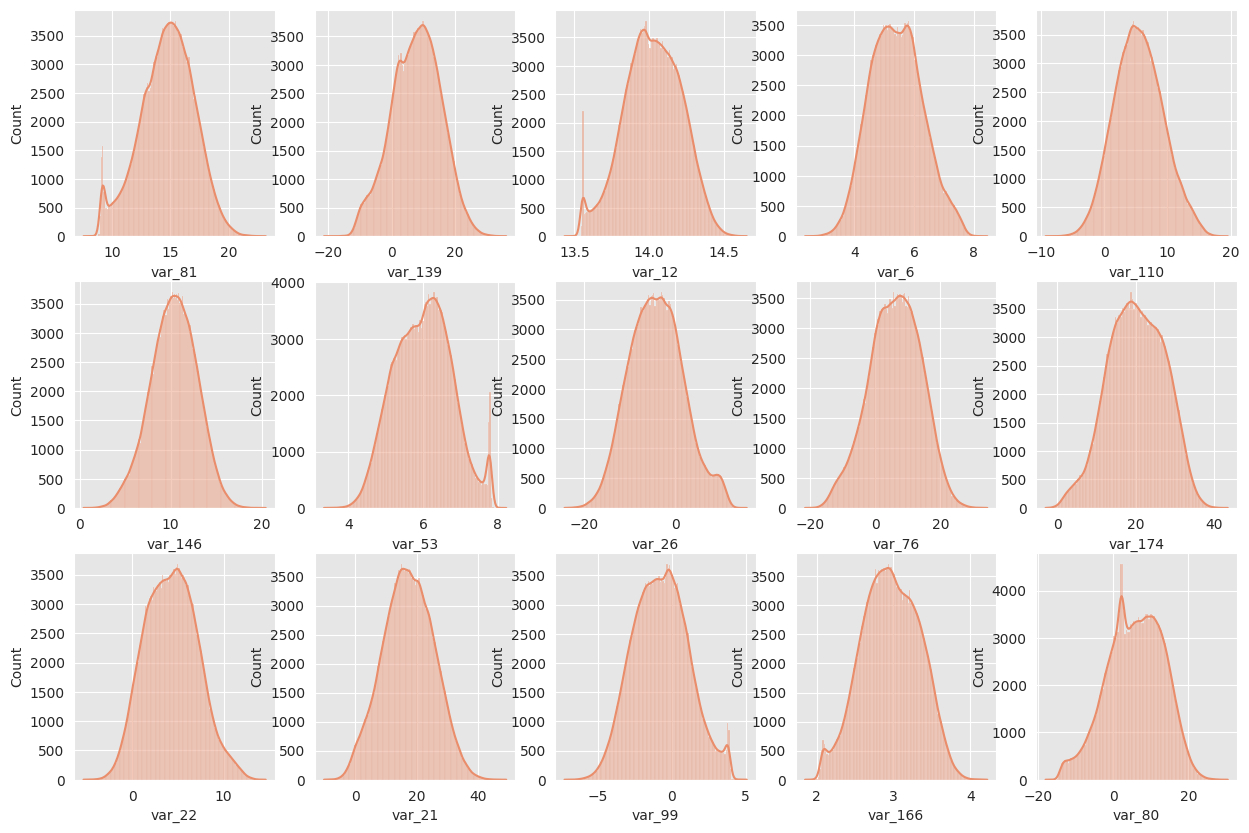

In [5]:
fig, axes = plt.subplots(3,5,figsize=(15,10))
axes = axes.flatten()

for f,i in enumerate(significant_features):
    sns.histplot(kde=True, x=train_df[i], ax=axes[f])

We will check distribution of target variable

<AxesSubplot: xlabel='target', ylabel='count'>

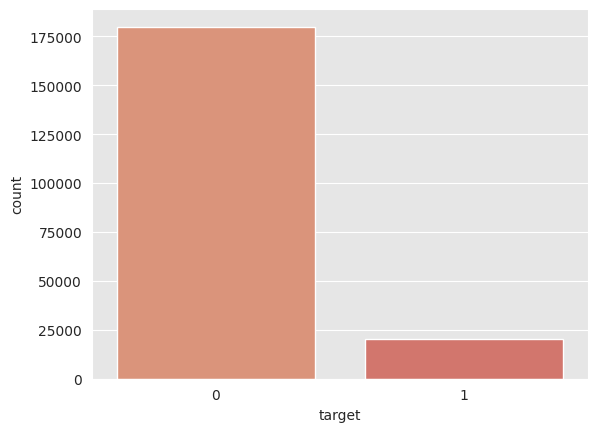

In [6]:
sns.countplot(x=train_df['target'])

This is kinda big problem. We can notice that our classes are unbalanced. Solutions for problem like that is oversampling, undersampling or randomsampling.

**We will check now distribution Train data vs Test data for all rows.
One method of comparing the distributions between the train and test sets is to calculate the mean, median, standard deviation, etc. for each column in the train set and compare the same values for the test set. If the means or standard deviations differ significantly between the train and test sets, it may indicate problems with the model's generalization.**

<AxesSubplot: ylabel='Count'>

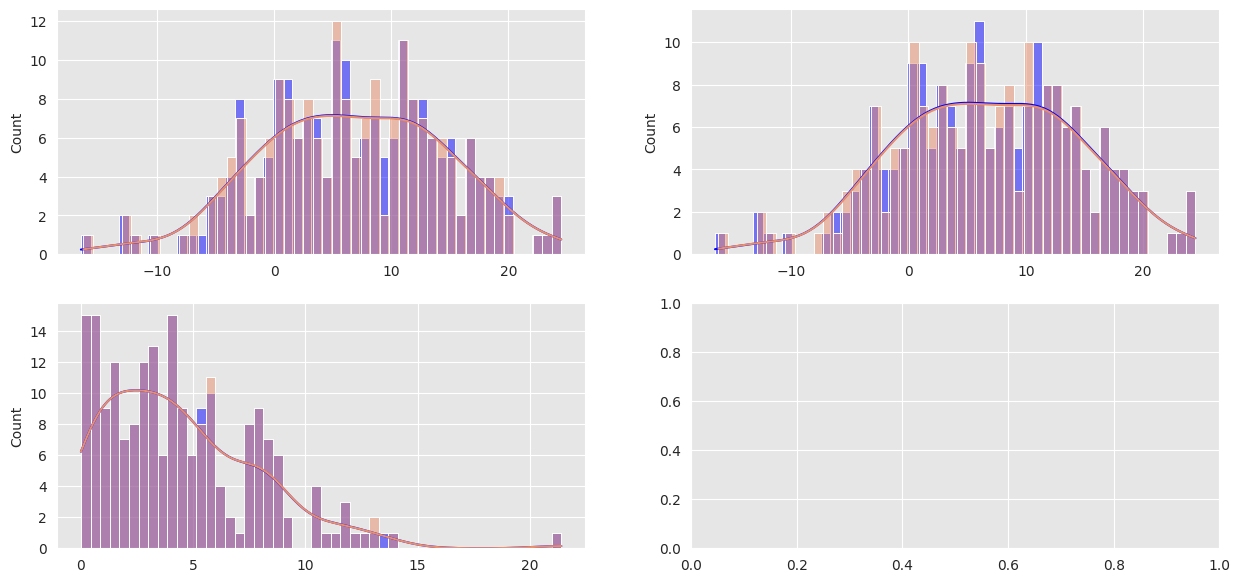

In [7]:
fig, axes = plt.subplots(2,2, figsize=(15,7))
axes=axes.flatten()

sns.histplot(x=train_df[features].mean(), kde=True, ax=axes[0], bins=50, color='b')
sns.histplot(x=test_df[features].mean(), kde=True, ax=axes[0], bins=50)

sns.histplot(x=train_df[features].median(), kde=True, ax=axes[1], bins=50, color='b')
sns.histplot(x=test_df[features].median(), kde=True, ax=axes[1], bins=50)

sns.histplot(x=train_df[features].std(), kde=True, ax=axes[2], bins=50, color='b')
sns.histplot(x=test_df[features].std(), kde=True, ax=axes[2], bins=50)

As we can see - from graphs - we shouldn't have problem with generalization in data. Both - test and train sets - are quite similar.

**We will also check if there are columns wich values duplicate. That would mean that the variance of given column is low and. Maybe we could find a similar pattern in test columns and just use it to assign proper class?**

In [8]:
display(train_df.var().sort_values(ascending=True)[0:10])
display(test_df.var().sort_values(ascending=True)[0:10])

var_68     0.000052
var_91     0.023299
var_108    0.029272
var_103    0.034232
var_12     0.036123
var_148    0.039678
var_161    0.047497
var_71     0.071127
var_25     0.081530
target     0.090392
dtype: float64

var_68     0.000052
var_91     0.023482
var_108    0.029391
var_103    0.034334
var_12     0.036127
var_148    0.039426
var_161    0.047496
var_71     0.070935
var_25     0.081484
var_43     0.096055
dtype: float64

As we can see - there are variables with very low variance both on train and test data. That could be important thing for the future.

**To sum up:
a) We have to use RobustScaler on our data to see if it will improve our scores
b) We will use CatBoost for now as an our model**

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df['target'], random_state=13, test_size=0.2)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
model = CatBoostClassifier(loss_function="Logloss",
                           eval_metric="AUC",
                           learning_rate=0.01,
                           random_seed=42,
                           od_type="Iter",
                           depth=5,
                           early_stopping_rounds=500,
                           verbose=False)
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, y_pred)

0.9119773880496229

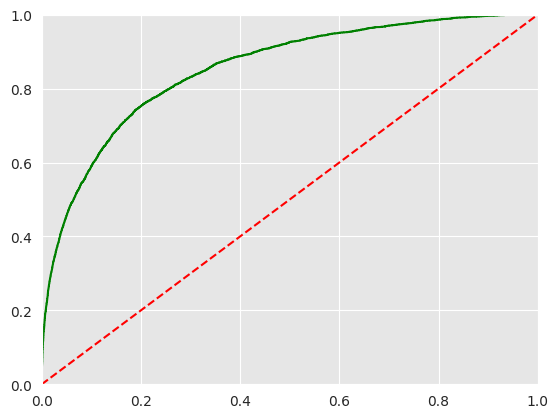

In [11]:
plt.plot(fpr, tpr, color='green', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Baseline')
plt.xlim([0, 1])
plt.ylim([0, 1])
display(roc_auc_score(model.predict(X_test), y_test))

As we can see - for Catboost ROC AUC Score is 90%. But the most important thing is how it is going to perform on main validation data where we don't know target values.

In [12]:
# That part is about evaluating our model on new test data and check score thru Kaggle Competitions
x = scaler.transform(test_df)
predictions = model.predict(x)
submission = pd.DataFrame({'ID_code': test_df.index, 'target': predictions})

# zapisanie DataFrame do pliku CSV
submission.to_csv('submission.csv', index=False)

# To do...
* Test LightGBM
* Explore more relations between variables - test variables too
* Improve competition score